## Car Fuel Efficiency modeling

### Import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file, plot_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(style='white')
plt.style.use('seaborn-white')

### data load

In [3]:
dataset_path = get_file('auti-mpg.data','http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

In [4]:
dataset_path

'/Users/psh/.keras/datasets/auti-mpg.data'

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration','Model Year','Origin']

### data check

In [6]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values='?',comment='\t',
                      sep=' ',skipinitialspace=True)

dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### data preprocessing

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

### one hot encoding

In [9]:
dataset['Origin'].value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [10]:
origin = dataset.pop('Origin')

In [11]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japan'] = (origin==3)*1.0
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


### make train dataset

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### EDA

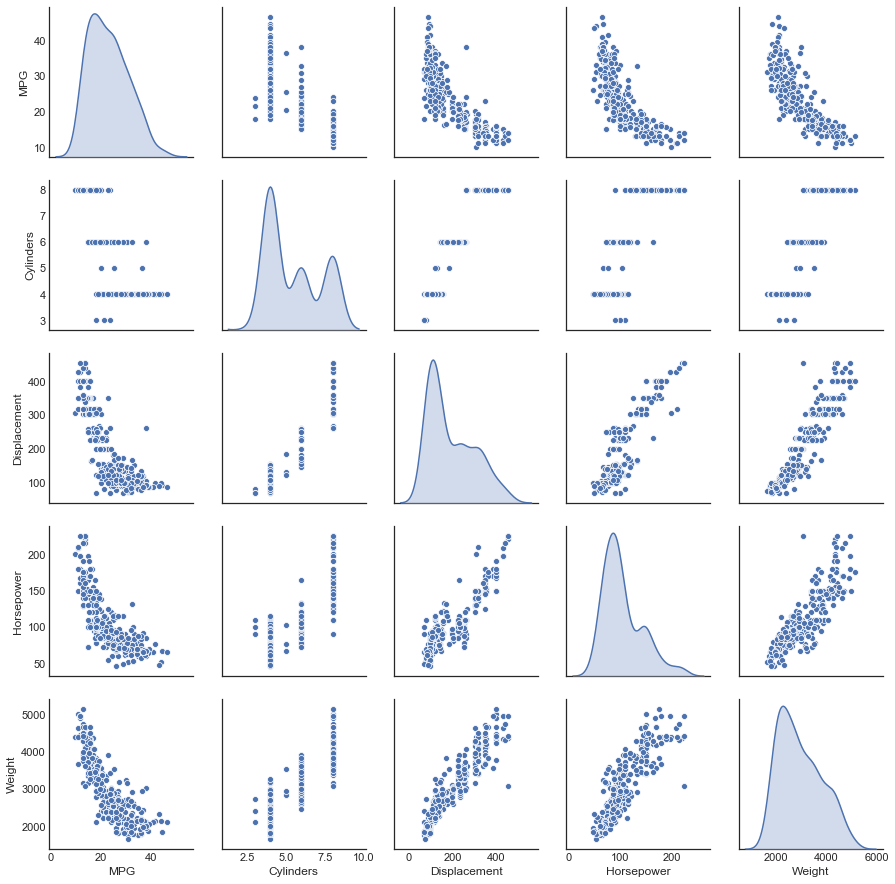

In [13]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement',
                            'Horsepower','Weight']], diag_kind='kde')

In [14]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [15]:
train_labels = train_dataset.pop('MPG')
test_labesls = test_dataset.pop('MPG')

### data nomalization

In [16]:
def nomalization(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = nomalization(train_dataset)
normed_test_data = nomalization(test_dataset)

### make model

In [17]:
def build_model():
    input = Input(shape=(len(train_dataset.keys())), name='input')
    hidden1 = Dense(64, activation='relu', name='dense1')(input)
    hidden2 = Dense(64, activation='relu', name='dense2')(hidden1)
    output = Dense(1, name='output')(hidden2)
    
    model = Model(inputs=[input], outputs=output)
    
    model.compile(loss='mse',
                 optimizer=RMSprop(0.001),
                 metrics=['mae','mse'])
    
    return model

In [18]:
model = build_model()

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 9)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 64)                640       
_________________________________________________________________
dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [20]:
plot_model(model)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


### check sample

In [21]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### model train

In [22]:
epochs = 1000

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                   validation_split=0.2, verbose=0)

In [23]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,553.630387,22.261560,553.630371,537.935270,21.901875,537.935242,0
1,499.971746,21.063837,499.971741,481.580306,20.613283,481.580292,1
2,447.994493,19.839296,447.994476,422.111447,19.166313,422.111450,2
3,391.585837,18.425503,391.585846,358.097905,17.487789,358.097900,3
4,331.225559,16.802065,331.225555,291.022598,15.556558,291.022614,4
...,...,...,...,...,...,...,...
995,2.210629,0.979690,2.210629,8.765358,2.273209,8.765358,995
996,2.273681,1.008177,2.273681,8.821268,2.268117,8.821269,996
997,2.289193,0.986694,2.289193,8.587148,2.234145,8.587149,997
998,2.408585,0.990899,2.408585,8.569656,2.227692,8.569655,998


### visualization

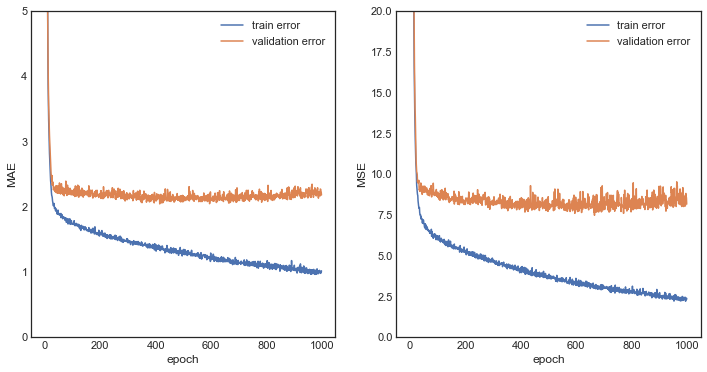

In [25]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('MAE')
    plt.plot(hist['epoch'],hist['mae'],label='train error')
    plt.plot(hist['epoch'],hist['val_mae'],label='validation error')
    plt.ylim([0,5 ])
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.plot(hist['epoch'],hist['mse'],label='train error')
    plt.plot(hist['epoch'],hist['val_mse'],label='validation error')
    plt.ylim([0,20])
    plt.legend()
    
    plt.show()
    
plot_history(history)

### early-stopping regularization

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
model = build_model()

early_stop = EarlyStopping(monitor='val_loss',patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                   validation_split=0.2, callbacks=[early_stop],
                   verbose = 0)

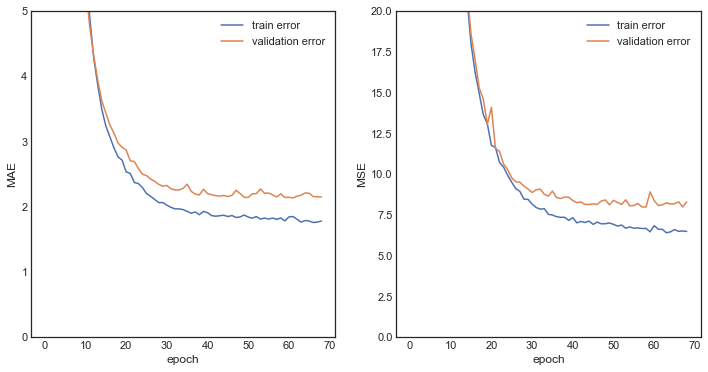

In [29]:
plot_history(history)

### model evaluation

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labesls, verbose=2)

print(mae)

78/78 - 0s - loss: 5.8987 - mae: 1.9263 - mse: 5.8987
1.9262586


### predict

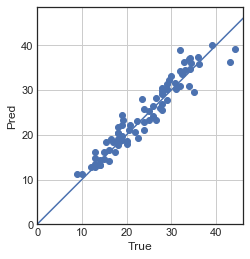

In [40]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labesls, test_pred)
plt.xlabel('True')
plt.ylabel('Pred')
plt.axis('square')
plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100,100],[-100,100])

plt.show()

Text(0, 0.5, 'count')

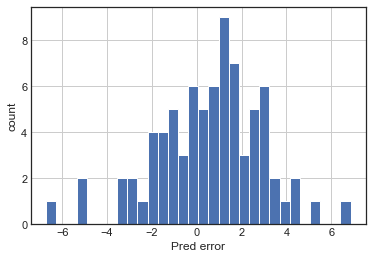

In [42]:
error = test_pred - test_labesls
plt.hist(error, bins=30)
plt.xlabel('Pred error')
plt.grid()
plt.ylabel('count')

### + weight initialization